In [3]:
#imports
import numpy as np
import core as mr
import matplotlib.pyplot as plt
import time

In [4]:
#parameters of the UR5 robot

M01 = [[1, 0, 0, 0], 
       [0, 1, 0, 0], 
       [0, 0, 1, 0.089159], 
       [0, 0, 0, 1]]

M12 = [[0, 0, 1, 0.28], 
       [0, 1, 0, 0.13585], 
       [-1, 0, 0, 0], 
       [0, 0, 0, 1]]

M23 = [[1, 0, 0, 0], 
       [0, 1, 0, -0.1197], 
       [0, 0, 1, 0.395], 
       [0, 0, 0, 1]]

M34 = [[0, 0, 1, 0], 
       [0, 1, 0, 0], 
       [-1, 0, 0, 0.14225], 
       [0, 0, 0, 1]]

M45 = [[1, 0, 0, 0], 
       [0, 1, 0, 0.093], 
       [0, 0, 1, 0], 
       [0, 0, 0, 1]]

M56 = [[1, 0, 0, 0], 
       [0, 1, 0, 0], 
       [0, 0, 1, 0.09465], 
       [0, 0, 0, 1]]

M67 = [[1, 0, 0, 0], 
       [0, 0, 1, 0.0823], 
       [0, -1, 0, 0], 
       [0, 0, 0, 1]]

G1 = np.diag([0.010267495893, 0.010267495893,  0.00666, 3.7, 3.7, 3.7])
G2 = np.diag([0.22689067591, 0.22689067591, 0.0151074, 8.393, 8.393, 8.393])
G3 = np.diag([0.049443313556, 0.049443313556, 0.004095, 2.275, 2.275, 2.275])
G4 = np.diag([0.111172755531, 0.111172755531, 0.21942, 1.219, 1.219, 1.219])
G5 = np.diag([0.111172755531, 0.111172755531, 0.21942, 1.219, 1.219, 1.219])
G6 = np.diag([0.0171364731454, 0.0171364731454, 0.033822, 0.1879, 0.1879, 0.1879])

In [5]:
Glist = [G1, G2, G3, G4, G5, G6]
Mlist = [M01, M12, M23, M34, M45, M56, M67] 

Slist = [[0,         0,         0,         0,        0,        0],
         [0,         1,         1,         1,        0,        1],
         [1,         0,         0,         0,       -1,        0],
         [0, -0.089159, -0.089159, -0.089159, -0.10915, 0.005491],
         [0,         0,         0,         0,  0.81725,        0],
         [0,         0,     0.425,   0.81725,        0,  0.81725]]

In [37]:
#helper functions
def write_csv_line(csv_filename, data):
    with open(csv_filename, 'a') as f:
        data_str = ','.join([str(i) for i in data]) + '\n'
        f.write(data_str)
###

def write_csv_mat(csv_filename, mat):
    f = open(csv_filename, 'w') #clear out old data
    f.close()
    for row in mat:
            write_csv_line(csv_filename, row)
###
    
def ModEulerStep(thetalist, dthetalist, ddthetalist, dt):
    """EulerStep from the MR library, but with an additional
    second-order term from acceleration contributing to changes in position.
    """
    return thetalist + (dt * np.array(dthetalist) + 0.5 * dt**2 * np.array(dthetalist) ), \
           dthetalist + dt * np.array(ddthetalist)
###

In [38]:
#component functions for spring force, damping force, and simulation

def SpringForce(Slist, thetalist, Mlist, stiffness, springPos, restLength):
    '''
    - Calculates the "spring force" acting on the end effector
        of the robot, using position of end of spring, position
        of end effector, and spring parameters.
    - takes in:
        -Slist: list of screw axes in space frame 
        -thetalist: list of current joint angles 
        -Mlist: home configurations of each joint rel. to.
            each other
        -stiffness: scalar with spring constant
        -springPos: 3-vector position 
        -restLength: scalar with resting length of spring
    - calls:
        - T = FKinBody(M_endeff, Blist, thetalist)
        - [R,p] = TranstoRp(FKinBody)
        - x_diff = np.linalg.norm(deltap) - restLength
    - returns:
        Ftip, a 6x1 end-effector wrench caused by the spring force
    '''

    # - Find home configuration of end effector
    M_matrices = [np.matrix(M) for M in Mlist]
    M_ee = M_matrices[0] * \
            M_matrices[1] * \
            M_matrices[2] * \
            M_matrices[3] * \
            M_matrices[4] * \
            M_matrices[5] * \
            M_matrices[6]
    
    #     - apply product of exponentials in space frame
    Tsb = mr.FKinSpace(M_ee, Slist, thetalist)
    springPos_4_s = np.append(np.array(springPos), [1]) #add an extra 1 so we can multiply by transf. matrix
    springPos_4_s = np.matrix(springPos_4_s).T
    
    pb = mr.TransInv(Tsb) * springPos_4_s
    pb = np.array(pb[0:3].tolist())
    
    #springposn minus posn of end effector, in b,  will just be springposn - [0 0 0]
    dp = pb[:]
    
    #direction of force given by unit vector of springposn
    unit_dir = -dp / np.linalg.norm(dp)
    
    #magnitude of force given by (stiffness) * (norm(springPosn_b) - restlength)
    mag_force = stiffness * (np.linalg.norm(pb) - restLength)
    sf = (mag_force * unit_dir).T[0].tolist()
    Fb = np.array([0, 0, 0, sf[0], sf[1], sf[2]])
    
    return Fb.tolist()

def DampingForce(B, thetad_list):
    '''
    - Make a torque at each joint, equal to B * w
    - takes in:
        - damping constant B
        - thetad_list: an nd-array, where n = # of joints of robot
    - returns:
        - an nd-array of joint torques, where n = # of joints
    '''
    tau_list = -B * np.array(thetad_list)
    return tau_list.tolist()

In [39]:
#testing: plug in joint angles that give known positions; check that 
#position difference is close to expected values; force is a constant times that
M_matrices = [np.matrix(M) for M in Mlist]
M_ee = M_matrices[0] * \
        M_matrices[1] * \
        M_matrices[2] * \
        M_matrices[3] * \
        M_matrices[4] * \
        M_matrices[5] * \
        M_matrices[6]

robot_posn = [0.1, 0.3, 0.6]
R = np.identity(3)
T = mr.RpToTrans(R, robot_posn)
thetalist0 = [0.504, -0.168, -1.713, 4.131, 0.000, 0.000]
thetalist, success = mr.IKinSpace(Slist, M_ee, T, thetalist0, 0.001, 0.0001)
thetalist = thetalist.round(4).tolist()

# print(M_ee) #looks as expected in CoppeliaSim
# print(thetalist) #[0.8966, -0.0886, -1.5636, 3.2229, -1.5708, 0.6742]
# print(success)

spring_posn = [0.2, 0.4, 0.7]
stiffness = 1
restLength = 0
expected_wrench = [0, 0, 0, 0.1, 0.1, 0.1]

#check that spring force matches expected value
wrench = SpringForce(Slist, thetalist, Mlist, stiffness, spring_posn, restLength)
assert np.allclose(expected_wrench, wrench, rtol = 1E-4, atol = 1E-4) #---> this used the space frame

#with nonzero restLength
restLength = np.sqrt(3)/10
wrench = SpringForce(Slist, thetalist, Mlist, stiffness, spring_posn, restLength)
expected_wrench = np.array([0, 0, 0, 0, 0, 0])
assert np.allclose(expected_wrench, wrench, rtol = 1E-4, atol = 1E-4) #---> this used the space frame

thetalist = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
damping = 0.2
assert np.allclose(DampingForce(damping, thetalist), [-0.02, -0.04, -0.06, -0.08, -0.10, -0.12])

print("all assertions passed")

AssertionError: 

In [43]:
def Puppet(damping, stiffness, restLength, springPos,\
          tf, dt, \
          g, Mlist, Glist, Slist, \
          thetalist0, thetadlist0): 
    '''
    - takes in
        - damping stiffness restLength
        - g, Mlist, Glist, Slist (g may be 0 in one sim)
        - thetalist0, dthetalist0
    - calculates
        - end effector wrench Ftip
        - applied joint torques taulist
    - calls 
        - mr.ForwardDynamics(thetalist,dthetalist,taulist,
            g,Ftip,Mlist,Glist,Slist)
        - ModEulerStep(thetalist,dthetalist,ddthetalist,dt)
        - SpringForce()
        - DampingForce()
    - returns: a N x n matrix of joint values, N = # of timesteps,
        n = number of joints
    '''
    
    thetalist = np.array(thetalist0)
    thetadlist = np.array(thetadlist0)  
    t_array = np.arange(0, tf, dt)
    traj_array = np.zeros([len(t_array), len(thetalist)]) #N timesteps, n angles    
    
    to = time.time()
    realtime_array = np.zeros([2*len(t_array),1])
        
    for i, t in enumerate(t_array):
                
        #calculate forces; call ForwardDynamics() with starting values of t, td, tdd lists
        taulist = DampingForce(damping, thetadlist) 
        Fb_tip = SpringForce(Slist, thetalist, Mlist, stiffness, springPos, restLength)

        realtime_array[2*i] = time.time() - to
        thetaddlist = mr.ForwardDynamics(thetalist, thetadlist, taulist, \
                                            g, Fb_tip, Mlist, Glist, Slist)
        realtime_array[2*i + 1] = time.time() - to
        
        # - use numerical integration to find theta, thetad at next timestep
        thetalist_new, thetadlist_new = ModEulerStep(thetalist, thetadlist, thetaddlist, dt)
        
        # - store value of theta at next timestep in an array; reset theta and thetad       
        traj_array[i,:] = thetalist_new
        thetalist = thetalist_new
        thetadlist = thetadlist_new
        
    #may want to change names of inputs to exactly match the asst later
    #return traj_array, realtime_array
    return traj_array

###

#debug: format of Puppet call looks good


# Problem 1

In [44]:
#testing
damping = 0
stiffness = 0
restlength = 0
tf = 5
dt = 0.01

g = 9.81 * np.array([0, 0, -1])
thetalist0 = [0,0,0,0,0,0]
dthetalist0 =[0,0,0,0,0,0]
springPosn = [0, 1, 2]  

realtime0 = time.time()
traj_array, realtime_array = Puppet(damping, stiffness, restLength, springPosn, tf, dt, g, Mlist, Glist, Slist, thetalist0, dthetalist0)
realtimef = time.time()

print(f"Shape of Traj array: {traj_array.shape}")
print(f"Elapsed: {realtimef - realtime0}")

KeyboardInterrupt: 

In [41]:
%prun Puppet(damping, stiffness, restLength, springPosn, tf, dt, g, Mlist, Glist, Slist, thetalist0, dthetalist0)

In [ ]:
#show analysis of run time
print(open('prun0', 'r').read())

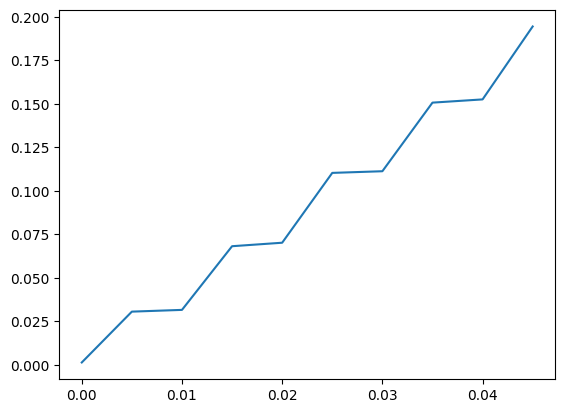

In [19]:
#analyze what part of the code the function is spending the most time in
n_iters = 5
realtime_array_small = realtime_array[:2*n_iters,0]
t_array_realtime = np.arange(0, n_iters * dt, dt/2).tolist()
plt.plot(t_array_realtime, realtime_array_small)

In [ ]:
#Post-Puppet:
write_csv_mat("HW3_p1_grav_fine.csv",traj_array)

# - import the CSV file into CoppeliaSim
# - adjust time multiplier so it takes 5s real time to play file.
#     record results for time multiplier.

#used time multiplier of about 3, but at this scale, motions don't appear realistic

# Problem 2

In [ ]:
#damping = 1.5 - underdamped
damping = 3
traj_damped_pos = Puppet(damping, stiffness, restLength, springPosn, tf, dt, g, Mlist, Glist, Slist, thetalist0, dthetalist0)
write_csv_mat("HW3_p2_damped_pos.csv",traj_damped_pos)


In [ ]:
damping = -0.00001
traj_damped_neg = Puppet(damping, stiffness, restLength, springPosn, tf, dt, g, Mlist, Glist, Slist, thetalist0, dthetalist0)

In [ ]:
#eventually this array blows up to infinity, so remove any nan terms
for i in range(len(traj_damped_neg)):
    row = traj_damped_neg[i,:]
    nanmask = np.isnan(row)
    if np.any(nanmask): #if NAN is in row; "True" in nanmask
        firstnan = i
        break

print(firstnan)
traj_damped_neg = traj_damped_neg[:firstnan]

In [ ]:
write_csv_mat("HW3_p2_damped_neg.csv",traj_damped_neg)

# Problem 3

In [58]:
#params for problem:
g = [0,0,0]
springPosn = [0,0,2]
stiffness = 8
restLength = 0
damping = 0

thetalist0 = [0,0,0,0,0,0]
dthetalist0 =[0,0,0,0,0,0]

tf = 10
dt = 0.01

realtime0 = time.time()
traj_spring = Puppet(damping, stiffness, restLength, springPosn, tf, dt, g, Mlist, Glist, Slist, thetalist0, dthetalist0)
realtimef = time.time()


In [59]:
write_csv_mat("HW3_p3_spring.csv",traj_spring)
print(f"Shape of Traj array: {traj_spring.shape}")
print(f"Elapsed: {realtimef - realtime0}")

Shape of Traj array: (1000, 6)
Elapsed: 108.73219561576843


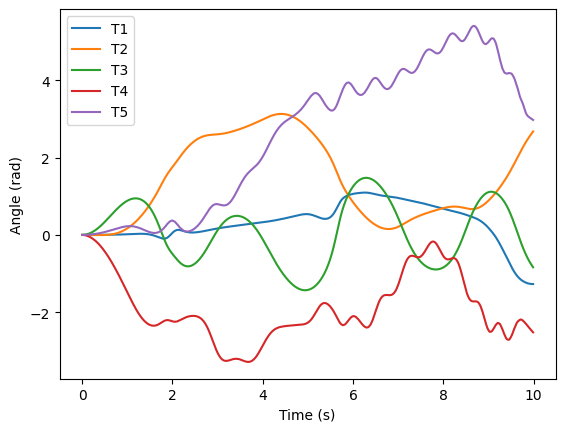

In [16]:
#check results by plotting trajectory over time
plt.clf()
t_array = np.arange(0, tf, dt)

plt.plot(t_array, traj_spring[:,0], label="T1")
plt.plot(t_array, traj_spring[:,1], label="T2")
plt.plot(t_array, traj_spring[:,2], label="T3")
plt.plot(t_array, traj_spring[:,3], label="T4")
plt.plot(t_array, traj_spring[:,4], label="T5")
# plt.plot(t_array, traj_spring[:,5], label="T6")


plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.legend()

Questions for Office Hours:
- Check on the energetic behavior of my system in the first problem. Looks like it could be feasible
    at time step = 1, but seems highly strange when time is normalized to 5s
    
    answer: starts off reasonable, then gets worse. he says it's likely a result of the integration getting
        worse and worse, due to EulerStep. not something to worry about too much, but I could decrease dt to check
            --> and keep that small dt for future problems
    
- getting some NANs and some behavior of the system blowing up to infinity with positive damping. Check about 
    why system is blowing up even with damping involved
    
        --other people got this as well with dt = 0.01, but it shouldn't behave this way, Kevin says
        
- functions are incredibly slow - without spring force, and especially with spring force. check if they have
    insight on how to optimize code, or if MR code is slow in general

In [60]:
#plot model with damping
#params for problem:
g = [0,0,0]
springPosn = [0,0,2]
stiffness = 8
restLength = 0
damping = 3

thetalist0 = [0,0,0,0,0,0]
dthetalist0 =[0,0,0,0,0,0]

tf = 10
dt = 0.01

realtime0 = time.time()
traj_spring_damped = Puppet(damping, stiffness, restLength, springPosn, tf, dt, g, Mlist, Glist, Slist, thetalist0, dthetalist0)
realtimef = time.time()


In [61]:
write_csv_mat("HW3_p3_spring_damped.csv",traj_spring_damped)
print(f"Shape of Traj array: {traj_spring_damped.shape}")
print(f"Elapsed: {realtimef - realtime0}")

Shape of Traj array: (1000, 6)
Elapsed: 127.94456481933594


ok, results of those values of damping and stiffness are pretty good! record some videos